In [1]:
import torch
from torch import nn, optim

from torchvision import transforms, datasets

In [2]:
def get_mnist_data():
  # create the transforms to turn images to tensors and normalize between -1 and 1
  compose = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Normalize((0.5), (0.5))
       ])
  return datasets.MNIST(root='./dataset', train=True, transform=compose, download=True)

In [3]:
data = get_mnist_data()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [4]:
from torch.utils.data import DataLoader

dl = DataLoader(data, batch_size=128, shuffle=True)

In [5]:
for x, y in dl:
  print(x.shape, y.shape)
  break

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [6]:
import torch.nn as nn
# create the discriminator which will be a classifier
class Discriminator(nn.Module):
  def __init__(self, inp_size, out_size):
    super().__init__()
    self.inp_size = inp_size
    self.out_size = out_size

    # create simple fc layers as the input will be the input pixels flattened
    self.fc1 = nn.Linear(self.inp_size, 1024)
    self.fc2 = nn.Linear(1024, 256)
    self.fc3 = nn.Linear(256, 64)
    self.fc4 = nn.Linear(64, self.out_size)

    self.relu = nn.LeakyReLU(0.2)
    self.drop = nn.Dropout(0.4)
    self.sig = nn.Sigmoid()
  

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(self.drop(x)))
    x = self.relu(self.fc3(self.drop(x)))
    x = self.sig(self.fc4(self.drop(x)))

    return x

In [7]:
# create a discriminator object to tell the difference between fake (0) and real (1) images
flat_img_shape = 28*28
disc = Discriminator(flat_img_shape, 1)

In [8]:
# helper functions for flat <-> unflat tensors
def flatten_vects(vects):
  return vects.view(vects.shape[0], -1)

def expand_vects(vects):
  img_dim = int(vects.shape[1] ** (1/2))
  return vects.view(vects.shape[0], 1, img_dim, img_dim)

In [9]:
class Generator(nn.Module):
  def __init__(self, latent_size, output_size):
    super().__init__()
    self.latent_size = latent_size
    self.output_size = output_size

    self.expand_fc1 = nn.Linear(self.latent_size, 256)
    self.expand_fc2 = nn.Linear(256, 512)
    self.expand_fc3 = nn.Linear(512, 1024)
    self.final_fc = nn.Linear(1024, self.output_size)

    self.relu = nn.LeakyReLU(0.2)
    self.drop = nn.Dropout(0.2)
    self.tanh = nn.Tanh()

  
  def forward(self, x):
    x = self.relu(self.expand_fc1(x))
    x = self.relu(self.expand_fc2(self.drop(x)))
    x = self.relu(self.expand_fc3(self.drop(x)))
    # use tanh as a final activation func to put outputs between -1 and 1 as done by the image normalizations
    x = self.tanh(self.final_fc(self.drop(x)))
    return x

In [10]:
latent_size = 100
gen = Generator(latent_size, flat_img_shape)

In [11]:
# make a function to generate noise in the size of the latent space
def noise(num_samples, latent_size):
  # create a vector of random samples from normal distribution with mean of 0 and variance of 1
  tens_noise = torch.randn(num_samples, latent_size)
  return tens_noise

In [12]:
test = noise(1, latent_size)
test.shape, test[0][:8]

(torch.Size([1, 100]),
 tensor([ 0.3523, -0.6113,  0.2694,  1.2612,  1.6308, -0.8591,  0.2523,  1.1668]))

In [13]:
# use lr provided from tutorial
d_optim = optim.Adam(disc.parameters(), lr=2e-4)
g_optim = optim.Adam(gen.parameters(), lr=2e-4)

In [14]:
# use bce loss for gen and discriminator loss
loss = nn.BCELoss()

In [15]:
def create_target(value, num_samples):
  if value == 0:
    target = torch.zeros(num_samples, 1)
  elif value == 1:
    target = torch.ones(num_samples, 1)
  else:
    raise ValueError(f'The value parameter for the function was {value} but expected either 0 or 1')
  
  return target

In [16]:
def train_discr(d_model, d_opt, real_data, fake_data):
  bs = real_data.size(0)
  # reset grad
  d_opt.zero_grad()

  # train on real
  pred_real = d_model(real_data)
  targ_real = create_target(1, bs)
  # calculate the loss as  | -log(Discr(real_data)) = -log(pred_real) = loss(pred_real, targ_real) in code | since all targets will have value 1
  error_real = loss(pred_real, targ_real)
  error_real.backward()

  # train on fake
  pred_fake = d_model(fake_data)
  targ_fake = create_target(0, bs)
  # calculate loss as -log(1 - Disrc(Gen(latent_vectors)) = -log(1 - Discr(fake_data)) = -log(1 - pred_fake) = loss(pred_fake, targ_fake) since all targets will have value of 0
  error_fake = loss(pred_fake, targ_fake)
  error_fake.backward()

  # update discr weights together
  d_opt.step()

  # return the loss func as error_real + error_fake
  total_dicr_loss = error_real + error_fake
  return total_dicr_loss, pred_real, pred_fake

In [17]:
def train_gen(g_optim, d_model, fake_data):
  bs = fake_data.size(0)

  g_optim.zero_grad()

  # make prediction using discr -> discr(gen(latent_vector)) = discr(fake_data)
  pred_fake = d_model(fake_data)
  gen_targ = create_target(1, bs)
  # calculate loss as -log(discr(gen(latent_vector))) = -log(discr(fake_data)) -log(pred_fake) = loss(pred_fake, gen_targ) to optimize the generator making real looking images since all targets will have value of 1
  gen_error = loss(pred_fake, gen_targ)
  gen_error.backward()

  g_optim.step()

  return gen_error

In [18]:
# generate 8 latent vectors that we will use to validate the results
validation_noise = noise(10, latent_size)
validation_noise.shape

torch.Size([10, 100])

In [19]:
gen

Generator(
  (expand_fc1): Linear(in_features=100, out_features=256, bias=True)
  (expand_fc2): Linear(in_features=256, out_features=512, bias=True)
  (expand_fc3): Linear(in_features=512, out_features=1024, bias=True)
  (final_fc): Linear(in_features=1024, out_features=784, bias=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (drop): Dropout(p=0.2, inplace=False)
  (tanh): Tanh()
)

In [20]:
expand_vects(gen(validation_noise)).shape

torch.Size([10, 1, 28, 28])

In [21]:
from torchvision.utils import save_image
import os
epochs = 100

for epoch in range(epochs):
  # ignore y in the dataloader since this is an unsupervised technique to generate data -> y is real or fake (not the value of the number)
  for i_batch, (x, _) in enumerate(dl):
    bs = x.size(0)

    # train discriminator
    real_data = flatten_vects(x)
    # generate fake data but remove gradients since we do not want to update the generator
    fake_data = gen(noise(bs, latent_size)).detach()
    d_error, _, _ = train_discr(disc, d_optim, real_data, fake_data)

    # train generator
    # generate fake data while keeping gradients this time
    fake_data = gen(noise(bs, latent_size))
    g_error = train_gen(g_optim, disc, fake_data)


  # show progress - not in the form of stats but of images instead (just for this vanilla case) after each epoch
  valid_imgs = expand_vects(gen(validation_noise))
  for i, img in enumerate(valid_imgs):
    try:
      save_image(img, f'valid_images/ep_{epoch}_img_{i}.png')
    except:
      os.mkdir('valid_images')
      save_image(img, f'valid_images/ep_{epoch}_img_{i}.png')


In [22]:
# for i, img in enumerate(imgs):
#   try:
#     save_image(img, f'valid_images/ep_{epoch}_img_{i}.png')
#   except:
#     os.mkdir('valid_images')
#     save_image(img, f'valid_images/ep_{epoch}_img_{i}.png')


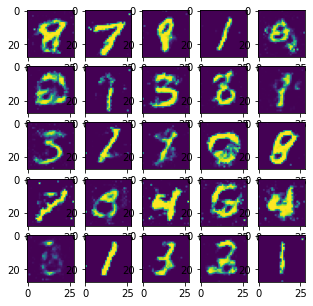

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

final_creations = gen(noise(25, latent_size))
img_creations = expand_vects(final_creations)

fig, axs = plt.subplots(5, 5, figsize=(5, 5))
img_idx = 0

for row in axs:
  for ax in row:
    ax.imshow(img_creations[img_idx].squeeze(0).detach())
    img_idx += 1

In [30]:
def show_results(num_res):
  sqrt_num_res = num_res ** (1/2)
  if sqrt_num_res - int(sqrt_num_res) != 0:
    raise Exception('Num res should be a perfect square (eg. 1, 4, 9, 16, 25, 36...)')
  sqrt_num_res = int(sqrt_num_res)
  
  creations = gen(noise(num_res, latent_size))
  img_creations = expand_vects(creations)

  fig, axs = plt.subplots(sqrt_num_res, sqrt_num_res, figsize=(5, 5))
  img_idx = 0

  for row in axs:
    for ax in row:
      ax.imshow(img_creations[img_idx].squeeze(0).detach())
      img_idx += 1

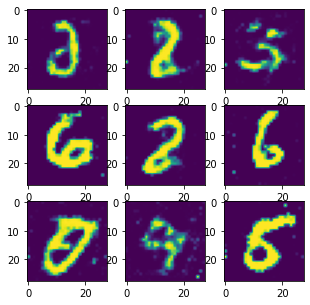

In [31]:
show_results(9)

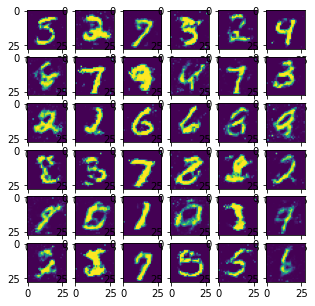

In [32]:
show_results(36)

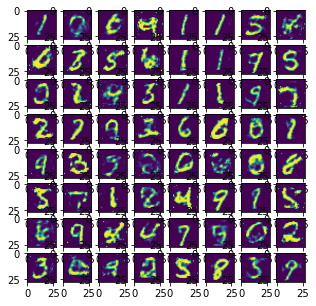

In [33]:
show_results(64)